In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [2]:
!pip install ../forks/tensortrade_source/ -U

Processing c:\users\codeninja\dev\forks\tensortrade_source
  Created wheel for tensortrade: filename=tensortrade-0.0.2rc0-cp37-none-any.whl size=56525 sha256=a56a7c7ccaddbbd50c27ef8a5cc06db6ebddbba47619ce5b7214b99138d722c5
  Stored in directory: C:\Users\CODENI~1\AppData\Local\Temp\pip-ephem-wheel-cache-3k1lxiom\wheels\62\be\3a\90782c795f0ba93fec4a55c551ac7e8f7e7ea933797e4f71c0
Successfully built tensortrade
  Found existing installation: tensortrade 0.0.2rc0
    Uninstalling tensortrade-0.0.2rc0:
      Successfully uninstalled tensortrade-0.0.2rc0


In [3]:
import os
import sys
import warnings
import numpy
import ccxt
import pandas as pd
import numpy as np
from time import time
import math
import cProfile as cp

from gym.spaces import Space, Box

config = './neat.config'

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.abspath('')+"\\tensortrade")


**Load Data**

In [4]:

data_file ='./data/processed/binance/btc_usdt_1h.csv' 
df = pd.read_csv(data_file, index_col=[0])


# number of days we want to pull from the dataframe 
days_of_data = 365

# number of data frames (our DF is in 1h timesteps)
frames = days_of_data * 24 * 5
# frames = len(df)
train_test_percentage = 0.4

x_train = int(frames * (1 - train_test_percentage))
x_test = int(frames - x_train)

df_train = df[-frames:(-x_test - 1)]
df_test = df[-x_test:]
print("Friend Shape", df.shape)
print('train shape', df_train.shape)
print('test shape', df_test.shape)
print('columns', df.columns)

Friend Shape (180236, 12)
train shape (26279, 12)
test shape (17520, 12)
columns Index(['open', 'high', 'low', 'close', 'volume', 'momentum_rsi', 'adx',
       'adx_long', 'adx_pos', 'adx_neg', 'trend_ema_fast', 'trend_ema_slow'],
      dtype='object')


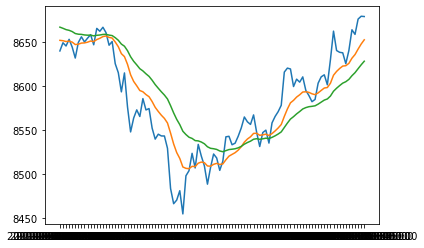

In [5]:
import matplotlib.pyplot as plt

# plt.subplot(221)
plt.plot(df_train[:100]['close'])
plt.plot(df_train[:100]['trend_ema_fast'])
plt.plot(df_train[:100]['trend_ema_slow'])

# plt.subplot(222)
# plt.plot(df_test[:200]['close'])
# plt.plot(df_test[:200]['trend_ema_fast'])
# plt.plot(df_test[:200]['trend_ema_slow'])

plt.show()

**Train against training data**

In [6]:
import tensortrade
from neat_trading_strategy import NeatTradingStrategy as TradingStrategy
from neat_reward_strategy import NeatRewardStrategy as ProfitStrategy
from tensortrade.actions import DiscreteActionStrategy as ActionStrategy
from tensortrade.exchanges.simulated import SimulatedExchange as Exchange
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features import FeaturePipeline
from tensortrade.environments import TradingEnvironment as Environment

print('fin imports')
normalize = MinMaxNormalizer(inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize])

reward_strategy = ProfitStrategy()
action_strategy = ActionStrategy(n_actions=20, instrument_symbol='BTC/USDT')
print('fin strats')

exchange = Exchange(data_frame=df_train,
                    pretransform = True,
                    base_instrument='USDT', 
                    commission_percent=0.75,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4,
                    observation_columns = df_train.columns
                   )
print('fin exchange')

environment = Environment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)
print('fin environment')
print('')
strategy = TradingStrategy(environment=environment, 
                           neat_config=config, 
                           watch_genome_evaluation=True,
                           only_show_profitable=True,
                           learn_to_trade_theshold=-10000,
                           data_frame_window = 2000
                          )

print("Running through ", strategy._data_frame_window, ' steps')
# cp.run("performance, winner, stats = strategy.run(generations=20)", 'evolution_stats')
performance, winner, stats = strategy.run(generations=20)

fin imports
fin strats
fin exchange
fin environment

Running through  2000  steps

 ****** Running generation 0 ****** 

---------------------------
0 11591.090770644285
10330 0 10000.0 10000.0 0 11591.090770644285 TradeType.MARKET_BUY
---------------------------
0 10148.380365664323
13598 0 10000.0 10000.0 0 10148.380365664323 TradeType.MARKET_BUY
0 10455.23678551687
13599 0 10000.0 10000.0 0 10455.23678551687 TradeType.MARKET_BUY
0 10303.501097771992
13600 0 10000.0 10000.0 0 10303.501097771992 TradeType.MARKET_BUY
0 10287.00846875648
13601 0 10000.0 10000.0 0 10287.00846875648 TradeType.MARKET_BUY
0 10333.40688613528
13602 0 10000.0 10000.0 0 10333.40688613528 TradeType.MARKET_BUY
0 10371.05703671961
13603 0 10000.0 10000.0 0 10371.05703671961 TradeType.MARKET_BUY
0 10174.81543422688
13604 0 10000.0 10000.0 0 10174.81543422688 TradeType.MARKET_BUY
0 10090.769466300415
13605 0 10000.0 10000.0 0 10090.769466300415 TradeType.MARKET_BUY
0 10388.88560238033
13606 0 10000.0 10000.0 0 1038

13689 0 10000.0 10000.0 0 10646.890698961595 TradeType.MARKET_BUY
0 10542.092562775164
13690 0 10000.0 10000.0 0 10542.092562775164 TradeType.MARKET_BUY
0 10599.473811058038
13691 0 10000.0 10000.0 0 10599.473811058038 TradeType.MARKET_BUY
0 10202.65493533281
13692 0 10000.0 10000.0 0 10202.65493533281 TradeType.MARKET_BUY
0 10362.392198639958
13693 0 10000.0 10000.0 0 10362.392198639958 TradeType.MARKET_BUY
0 10498.779543158267
13694 0 10000.0 10000.0 0 10498.779543158267 TradeType.MARKET_BUY
0 10257.221312294681
13695 0 10000.0 10000.0 0 10257.221312294681 TradeType.MARKET_BUY
0 10819.665783598632
13696 0 10000.0 10000.0 0 10819.665783598632 TradeType.MARKET_BUY
0 10816.133647694709
13697 0 10000.0 10000.0 0 10816.133647694709 TradeType.MARKET_BUY
0 10738.551932534214
13698 0 10000.0 10000.0 0 10738.551932534214 TradeType.MARKET_BUY
0 10509.047465867308
13699 0 10000.0 10000.0 0 10509.047465867308 TradeType.MARKET_BUY
0 10665.713331844494
13700 0 10000.0 10000.0 0 10665.713331844494 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




13806 0 10000.0 10000.0 0 10935.788139296676 TradeType.MARKET_BUY
0 11121.9708128815
13807 0 10000.0 10000.0 0 11121.9708128815 TradeType.MARKET_BUY
0 11173.396123158987
13808 0 10000.0 10000.0 0 11173.396123158987 TradeType.MARKET_BUY
0 10908.85260212466
13809 0 10000.0 10000.0 0 10908.85260212466 TradeType.MARKET_BUY
0 11195.243412812055
13810 0 10000.0 10000.0 0 11195.243412812055 TradeType.MARKET_BUY
0 10811.62322296116
13811 0 10000.0 10000.0 0 10811.62322296116 TradeType.MARKET_BUY
0 10795.544458526532
13812 0 10000.0 10000.0 0 10795.544458526532 TradeType.MARKET_BUY
0 11122.256206826523
13813 0 10000.0 10000.0 0 11122.256206826523 TradeType.MARKET_BUY
0 10845.836793991444
13814 0 10000.0 10000.0 0 10845.836793991444 TradeType.MARKET_BUY
0 11127.530569771687
13815 0 10000.0 10000.0 0 11127.530569771687 TradeType.MARKET_BUY
0 11029.187884685214
13816 0 10000.0 10000.0 0 11029.187884685214 TradeType.MARKET_BUY
0 11161.895708127851
13817 0 10000.0 10000.0 0 11161.895708127851 Trade

13900 0 10000.0 10000.0 0 10768.196731355954 TradeType.MARKET_BUY
0 11094.93069713224
13901 0 10000.0 10000.0 0 11094.93069713224 TradeType.MARKET_BUY
0 10519.11982777417
13902 0 10000.0 10000.0 0 10519.11982777417 TradeType.MARKET_BUY
0 10932.495543211164
13903 0 10000.0 10000.0 0 10932.495543211164 TradeType.MARKET_BUY
0 10985.899014356992
13904 0 10000.0 10000.0 0 10985.899014356992 TradeType.MARKET_BUY
0 10460.547964776695
13905 0 10000.0 10000.0 0 10460.547964776695 TradeType.MARKET_BUY
0 10414.0073746507
13906 0 10000.0 10000.0 0 10414.0073746507 TradeType.MARKET_BUY
0 10599.669074372474
13907 0 10000.0 10000.0 0 10599.669074372474 TradeType.MARKET_BUY
0 10452.651448733304
13908 0 10000.0 10000.0 0 10452.651448733304 TradeType.MARKET_BUY
0 10740.440362872681
13909 0 10000.0 10000.0 0 10740.440362872681 TradeType.MARKET_BUY
0 10995.838420656126
13910 0 10000.0 10000.0 0 10995.838420656126 TradeType.MARKET_BUY
0 10856.481223163915
13911 0 10000.0 10000.0 0 10856.481223163915 TradeT

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9690.140766134724 TradeType.MARKET_BUY
0 9703.405498950577
14022 0 10000.0 10000.0 0 9703.405498950577 TradeType.MARKET_BUY
0 9448.158951112273
14023 0 10000.0 10000.0 0 9448.158951112273 TradeType.MARKET_BUY
0 9520.00586591701
14024 0 10000.0 10000.0 0 9520.00586591701 TradeType.MARKET_BUY
0 9592.69157822398
14025 0 10000.0 10000.0 0 9592.69157822398 TradeType.MARKET_BUY
0 9895.631948760632
14026 0 10000.0 10000.0 0 9895.631948760632 TradeType.MARKET_BUY
0 9515.302858351013
14027 0 10000.0 10000.0 0 9515.302858351013 TradeType.MARKET_BUY
0 9777.019392675827
14028 0 10000.0 10000.0 0 9777.019392675827 TradeType.MARKET_BUY
0 9668.554871620368
14029 0 10000.0 10000.0 0 9668.554871620368 TradeType.MARKET_BUY
0 9508.766946794134
14030 0 10000.0 10000.0 0 9508.766946794134 TradeType.MARKET_BUY
0 9906.632882402982
14031 0 10000.0 10000.0 0 9906.632882402982 TradeType.MARKET_BUY
0 9731.20557795158
14032 0 10000.0 10000.0 0 9731.20557795158 TradeType.MARKET_BUY
0 9517.197502323688
14033 0 1000

14118 0 10000.0 10000.0 0 9273.675652078864 TradeType.MARKET_BUY
0 9478.910365204509
14119 0 10000.0 10000.0 0 9478.910365204509 TradeType.MARKET_BUY
0 9238.834296754061
14120 0 10000.0 10000.0 0 9238.834296754061 TradeType.MARKET_BUY
0 9375.425329531176
14121 0 10000.0 10000.0 0 9375.425329531176 TradeType.MARKET_BUY
0 9377.649084243858
14122 0 10000.0 10000.0 0 9377.649084243858 TradeType.MARKET_BUY
0 9439.0854682355
14123 0 10000.0 10000.0 0 9439.0854682355 TradeType.MARKET_BUY
0 9199.135956756443
14124 0 10000.0 10000.0 0 9199.135956756443 TradeType.MARKET_BUY
0 9131.869194591833
14125 0 10000.0 10000.0 0 9131.869194591833 TradeType.MARKET_BUY
0 9649.788926369101
14126 0 10000.0 10000.0 0 9649.788926369101 TradeType.MARKET_BUY
0 9388.414494474848
14127 0 10000.0 10000.0 0 9388.414494474848 TradeType.MARKET_BUY
0 9151.090405634799
14128 0 10000.0 10000.0 0 9151.090405634799 TradeType.MARKET_BUY
0 9224.897118771936
14129 0 10000.0 10000.0 0 9224.897118771936 TradeType.MARKET_BUY
0 94

0 9234.393252248503
14215 0 10000.0 10000.0 0 9234.393252248503 TradeType.MARKET_BUY
0 9065.385028125113
14216 0 10000.0 10000.0 0 9065.385028125113 TradeType.MARKET_BUY
0 9324.465999018123
14217 0 10000.0 10000.0 0 9324.465999018123 TradeType.MARKET_BUY
0 9053.20167505702
14218 0 10000.0 10000.0 0 9053.20167505702 TradeType.MARKET_BUY
0 9149.85868442074
14219 0 10000.0 10000.0 0 9149.85868442074 TradeType.MARKET_BUY
0 9338.785768777003
14220 0 10000.0 10000.0 0 9338.785768777003 TradeType.MARKET_BUY
0 9135.818512520762
14221 0 10000.0 10000.0 0 9135.818512520762 TradeType.MARKET_BUY
0 9141.470712520106
14222 0 10000.0 10000.0 0 9141.470712520106 TradeType.MARKET_BUY
0 9137.227817709441
14223 0 10000.0 10000.0 0 9137.227817709441 TradeType.MARKET_BUY
0 9118.695426272656
14224 0 10000.0 10000.0 0 9118.695426272656 TradeType.MARKET_BUY
0 9030.82276181511
14225 0 10000.0 10000.0 0 9030.82276181511 TradeType.MARKET_BUY
0 9234.611158382477
14226 0 10000.0 10000.0 0 9234.611158382477 TradeTy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 TradeType.MARKET_BUY
0 9899.032908665264
14338 0 10000.0 10000.0 0 9899.032908665264 TradeType.MARKET_BUY
0 9702.619212912334
14339 0 10000.0 10000.0 0 9702.619212912334 TradeType.MARKET_BUY
0 10149.222400059543
14340 0 10000.0 10000.0 0 10149.222400059543 TradeType.MARKET_BUY
0 9812.058203925182
14341 0 10000.0 10000.0 0 9812.058203925182 TradeType.MARKET_BUY
0 9842.454136231807
14342 0 10000.0 10000.0 0 9842.454136231807 TradeType.MARKET_BUY
0 9996.980781375414
14343 0 10000.0 10000.0 0 9996.980781375414 TradeType.MARKET_BUY
0 9673.989913152378
14344 0 10000.0 10000.0 0 9673.989913152378 TradeType.MARKET_BUY
0 9632.72188647401
14345 0 10000.0 10000.0 0 9632.72188647401 TradeType.MARKET_BUY
0 9681.389139215878
14346 0 10000.0 10000.0 0 9681.389139215878 TradeType.MARKET_BUY
0 9867.959579298475
14347 0 10000.0 10000.0 0 9867.959579298475 TradeType.MARKET_BUY
0 9842.637620245721
14348 0 10000.0 10000.0 0 9842.637620245721 TradeType.MARKET_BUY
0 9972.816622913151
14349 0 10000.0 10000.0

14434 0 10000.0 10000.0 0 9880.29895225431 TradeType.MARKET_BUY
0 9560.189457604683
14435 0 10000.0 10000.0 0 9560.189457604683 TradeType.MARKET_BUY
0 9801.602694334882
14436 0 10000.0 10000.0 0 9801.602694334882 TradeType.MARKET_BUY
0 10076.298368197084
14437 0 10000.0 10000.0 0 10076.298368197084 TradeType.MARKET_BUY
0 10098.968982356906
14438 0 10000.0 10000.0 0 10098.968982356906 TradeType.MARKET_BUY
0 10057.843233633637
14439 0 10000.0 10000.0 0 10057.843233633637 TradeType.MARKET_BUY
0 10031.60505102463
14440 0 10000.0 10000.0 0 10031.60505102463 TradeType.MARKET_BUY
0 9737.869736697923
14441 0 10000.0 10000.0 0 9737.869736697923 TradeType.MARKET_BUY
0 9971.397341237256
14442 0 10000.0 10000.0 0 9971.397341237256 TradeType.MARKET_BUY
0 9958.802882774788
14443 0 10000.0 10000.0 0 9958.802882774788 TradeType.MARKET_BUY
0 9776.978157070564
14444 0 10000.0 10000.0 0 9776.978157070564 TradeType.MARKET_BUY
0 9650.55927235144
14445 0 10000.0 10000.0 0 9650.55927235144 TradeType.MARKET_B

14530 0 10000.0 10000.0 0 9127.830071255252 TradeType.MARKET_BUY
0 9329.489004304638
14531 0 10000.0 10000.0 0 9329.489004304638 TradeType.MARKET_BUY
0 9530.37177230104
14532 0 10000.0 10000.0 0 9530.37177230104 TradeType.MARKET_BUY
0 9579.397945727813
14533 0 10000.0 10000.0 0 9579.397945727813 TradeType.MARKET_BUY
0 9570.865471024277
14534 0 10000.0 10000.0 0 9570.865471024277 TradeType.MARKET_BUY
0 9434.840872243389
14535 0 10000.0 10000.0 0 9434.840872243389 TradeType.MARKET_BUY
0 9544.373295215391
14536 0 10000.0 10000.0 0 9544.373295215391 TradeType.MARKET_BUY
0 9389.329962642525
14537 0 10000.0 10000.0 0 9389.329962642525 TradeType.MARKET_BUY
0 9216.552792964383
14538 0 10000.0 10000.0 0 9216.552792964383 TradeType.MARKET_BUY
0 9187.081228116816
14539 0 10000.0 10000.0 0 9187.081228116816 TradeType.MARKET_BUY
0 9531.876214144568
14540 0 10000.0 10000.0 0 9531.876214144568 TradeType.MARKET_BUY
0 9620.525849660167
14541 0 10000.0 10000.0 0 9620.525849660167 TradeType.MARKET_BUY
0 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TradeType.MARKET_BUY
0 10677.843672902205
14592 0 10000.0 10000.0 0 10677.843672902205 TradeType.MARKET_BUY
0 10425.79981469351
14593 0 10000.0 10000.0 0 10425.79981469351 TradeType.MARKET_BUY
0 10787.709397237351
14594 0 10000.0 10000.0 0 10787.709397237351 TradeType.MARKET_BUY
0 10776.558642034006
14595 0 10000.0 10000.0 0 10776.558642034006 TradeType.MARKET_BUY
0 10629.160429087957
14596 0 10000.0 10000.0 0 10629.160429087957 TradeType.MARKET_BUY
0 10329.60938350577
14597 0 10000.0 10000.0 0 10329.60938350577 TradeType.MARKET_BUY
0 10317.486811090812
14598 0 10000.0 10000.0 0 10317.486811090812 TradeType.MARKET_BUY
0 10596.120120556418
14599 0 10000.0 10000.0 0 10596.120120556418 TradeType.MARKET_BUY
0 10696.094469560609
14600 0 10000.0 10000.0 0 10696.094469560609 TradeType.MARKET_BUY
0 10342.334239147349
14601 0 10000.0 10000.0 0 10342.334239147349 TradeType.MARKET_BUY
0 10252.872322366999
14602 0 10000.0 10000.0 0 10252.872322366999 TradeType.MARKET_BUY
0 10579.975057349939
14603

14686 0 10000.0 10000.0 0 10751.384047550568 TradeType.MARKET_BUY
0 10331.614106324036
14687 0 10000.0 10000.0 0 10331.614106324036 TradeType.MARKET_BUY
0 10701.332059448554
14688 0 10000.0 10000.0 0 10701.332059448554 TradeType.MARKET_BUY
0 10697.175328877083
14689 0 10000.0 10000.0 0 10697.175328877083 TradeType.MARKET_BUY
0 10877.447384451236
14690 0 10000.0 10000.0 0 10877.447384451236 TradeType.MARKET_BUY
0 10833.520092706824
14691 0 10000.0 10000.0 0 10833.520092706824 TradeType.MARKET_BUY
0 10426.240669831177
14692 0 10000.0 10000.0 0 10426.240669831177 TradeType.MARKET_BUY
0 10535.792594827266
14693 0 10000.0 10000.0 0 10535.792594827266 TradeType.MARKET_BUY
0 10912.596477267974
14694 0 10000.0 10000.0 0 10912.596477267974 TradeType.MARKET_BUY
0 10736.0898935171
14695 0 10000.0 10000.0 0 10736.0898935171 TradeType.MARKET_BUY
0 10315.949979830046
14696 0 10000.0 10000.0 0 10315.949979830046 TradeType.MARKET_BUY
0 10324.183349339897
14697 0 10000.0 10000.0 0 10324.183349339897 Tr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 10334.514603657795
14807 0 10000.0 10000.0 0 10334.514603657795 TradeType.MARKET_BUY
0 10774.710330043152
14808 0 10000.0 10000.0 0 10774.710330043152 TradeType.MARKET_BUY
0 10185.891639582424
14809 0 10000.0 10000.0 0 10185.891639582424 TradeType.MARKET_BUY
0 10195.38257827274
14810 0 10000.0 10000.0 0 10195.38257827274 TradeType.MARKET_BUY
0 10472.575241612149
14811 0 10000.0 10000.0 0 10472.575241612149 TradeType.MARKET_BUY
0 10296.387017980167
14812 0 10000.0 10000.0 0 10296.387017980167 TradeType.MARKET_BUY
0 10411.883686871692
14813 0 10000.0 10000.0 0 10411.883686871692 TradeType.MARKET_BUY
0 10489.212944877265
14814 0 10000.0 10000.0 0 10489.212944877265 TradeType.MARKET_BUY
0 9920.252735608872
14815 0 10000.0 10000.0 0 9920.252735608872 TradeType.MARKET_BUY
0 10300.602228669499
14816 0 10000.0 10000.0 0 10300.602228669499 TradeType.MARKET_BUY
0 10439.562483303787
14817 0 10000.0 10000.0 0 10439.562483303787 TradeType.MARKET_BUY
0 10160.42126032089
14818 0 10000.0 10000.0 0 1

14901 0 10000.0 10000.0 0 10241.147050932894 TradeType.MARKET_BUY
0 10358.893918042117
14902 0 10000.0 10000.0 0 10358.893918042117 TradeType.MARKET_BUY
0 10201.457952246688
14903 0 10000.0 10000.0 0 10201.457952246688 TradeType.MARKET_BUY
0 10233.353413639148
14904 0 10000.0 10000.0 0 10233.353413639148 TradeType.MARKET_BUY
0 10430.96631942536
14905 0 10000.0 10000.0 0 10430.96631942536 TradeType.MARKET_BUY
0 10760.300545115751
14906 0 10000.0 10000.0 0 10760.300545115751 TradeType.MARKET_BUY
0 10572.19202092023
14907 0 10000.0 10000.0 0 10572.19202092023 TradeType.MARKET_BUY
0 10574.85280716386
14908 0 10000.0 10000.0 0 10574.85280716386 TradeType.MARKET_BUY
0 10722.635165251342
14909 0 10000.0 10000.0 0 10722.635165251342 TradeType.MARKET_BUY
0 10471.271777075917
14910 0 10000.0 10000.0 0 10471.271777075917 TradeType.MARKET_BUY
0 10784.755661518986
14911 0 10000.0 10000.0 0 10784.755661518986 TradeType.MARKET_BUY
0 10465.849288408015
14912 0 10000.0 10000.0 0 10465.849288408015 Trad

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15019 0 10000.0 10000.0 0 10738.00540541732 TradeType.MARKET_BUY
0 10452.957595666197
15020 0 10000.0 10000.0 0 10452.957595666197 TradeType.MARKET_BUY
0 10257.579166650816
15021 0 10000.0 10000.0 0 10257.579166650816 TradeType.MARKET_BUY
0 10536.822164602883
15022 0 10000.0 10000.0 0 10536.822164602883 TradeType.MARKET_BUY
0 10644.040342716662
15023 0 10000.0 10000.0 0 10644.040342716662 TradeType.MARKET_BUY
0 10375.95872146796
15024 0 10000.0 10000.0 0 10375.95872146796 TradeType.MARKET_BUY
0 10546.040147637264
15025 0 10000.0 10000.0 0 10546.040147637264 TradeType.MARKET_BUY
0 10303.285585288084
15026 0 10000.0 10000.0 0 10303.285585288084 TradeType.MARKET_BUY
0 10431.18124504916
15027 0 10000.0 10000.0 0 10431.18124504916 TradeType.MARKET_BUY
0 10796.995386072642
15028 0 10000.0 10000.0 0 10796.995386072642 TradeType.MARKET_BUY
0 10887.546605475374
15029 0 10000.0 10000.0 0 10887.546605475374 TradeType.MARKET_BUY
0 10330.778126232479
15030 0 10000.0 10000.0 0 10330.778126232479 Tra

15113 0 10000.0 10000.0 0 10718.420639727836 TradeType.MARKET_BUY
0 10620.786099576899
15114 0 10000.0 10000.0 0 10620.786099576899 TradeType.MARKET_BUY
0 10834.535044119932
15115 0 10000.0 10000.0 0 10834.535044119932 TradeType.MARKET_BUY
0 10758.31357989239
15116 0 10000.0 10000.0 0 10758.31357989239 TradeType.MARKET_BUY
0 10496.788877796876
15117 0 10000.0 10000.0 0 10496.788877796876 TradeType.MARKET_BUY
0 10344.116167009528
15118 0 10000.0 10000.0 0 10344.116167009528 TradeType.MARKET_BUY
0 10252.161835746803
15119 0 10000.0 10000.0 0 10252.161835746803 TradeType.MARKET_BUY
0 10853.991651156353
15120 0 10000.0 10000.0 0 10853.991651156353 TradeType.MARKET_BUY
0 10731.168904531014
15121 0 10000.0 10000.0 0 10731.168904531014 TradeType.MARKET_BUY
0 10651.179011771434
15122 0 10000.0 10000.0 0 10651.179011771434 TradeType.MARKET_BUY
0 10551.380372549289
15123 0 10000.0 10000.0 0 10551.380372549289 TradeType.MARKET_BUY
0 10450.171450524998
15124 0 10000.0 10000.0 0 10450.171450524998 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15236 0 10000.0 10000.0 0 10567.755272463352 TradeType.MARKET_BUY
0 10831.697636104142
15237 0 10000.0 10000.0 0 10831.697636104142 TradeType.MARKET_BUY
0 11053.394341506637
15238 0 10000.0 10000.0 0 11053.394341506637 TradeType.MARKET_BUY
0 10743.336391904502
15239 0 10000.0 10000.0 0 10743.336391904502 TradeType.MARKET_BUY
0 10933.862627706483
15240 0 10000.0 10000.0 0 10933.862627706483 TradeType.MARKET_BUY
0 10697.779696219104
15241 0 10000.0 10000.0 0 10697.779696219104 TradeType.MARKET_BUY
0 10719.648032819801
15242 0 10000.0 10000.0 0 10719.648032819801 TradeType.MARKET_BUY
0 10931.063789933905
15243 0 10000.0 10000.0 0 10931.063789933905 TradeType.MARKET_BUY
0 10889.607229769781
15244 0 10000.0 10000.0 0 10889.607229769781 TradeType.MARKET_BUY
0 10486.77459460623
15245 0 10000.0 10000.0 0 10486.77459460623 TradeType.MARKET_BUY
0 10452.634888847893
15246 0 10000.0 10000.0 0 10452.634888847893 TradeType.MARKET_BUY
0 10958.711372932094
15247 0 10000.0 10000.0 0 10958.711372932094 

15409 0 10000.0 10000.0 0 10594.782553004106 TradeType.MARKET_BUY
0 10576.075885326836
15410 0 10000.0 10000.0 0 10576.075885326836 TradeType.MARKET_BUY
0 10545.26939450925
15411 0 10000.0 10000.0 0 10545.26939450925 TradeType.MARKET_BUY
0 10472.47200310615
15412 0 10000.0 10000.0 0 10472.47200310615 TradeType.MARKET_BUY
0 10529.871750397378
15413 0 10000.0 10000.0 0 10529.871750397378 TradeType.MARKET_BUY
0 10231.604465399254
15414 0 10000.0 10000.0 0 10231.604465399254 TradeType.MARKET_BUY
0 10560.359117169142
15415 0 10000.0 10000.0 0 10560.359117169142 TradeType.MARKET_BUY
0 10299.63525420386
15416 0 10000.0 10000.0 0 10299.63525420386 TradeType.MARKET_BUY
0 10637.816304376278
15417 0 10000.0 10000.0 0 10637.816304376278 TradeType.MARKET_BUY
0 10416.773626802766
15418 0 10000.0 10000.0 0 10416.773626802766 TradeType.MARKET_BUY
0 10450.393575398673
15419 0 10000.0 10000.0 0 10450.393575398673 TradeType.MARKET_BUY
0 10090.949216055298
15420 0 10000.0 10000.0 0 10090.949216055298 Trad

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
exchange.trades

In [ ]:
# import pstats
# from pstats import SortKey
# p = pstats.Stats('evolution_stats')
# p.strip_dirs().sort_stats("cumtime").print_stats(20)

**Evaluate against full dataset**

In [ ]:
exchange = Exchange(data_frame=df,
                    should_pretransform_obs = True,
                    base_instrument='USDT', 
                    timeframe='1h',
                    dtype=np.float32,
                    commission_percent=0.5,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4
                   )
environment = Environment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)

environment.reset()
from neat_trading_strategy import NeatTradingStrategy as TradingStrategy

strategy = TradingStrategy(environment=environment, watch_genome_evaluation=True, full_evaluation = True, neat_config=config)

In [ ]:
strategy.eval_genome(winner)

In [ ]:
print(environment.exchange.trades)
environment.exchange.performance.net_worth.plot()

In [ ]:
import visualize

visualize.plot_stats(stats, ylog=False, view=True)


In [ ]:
visualize.plot_species(stats, view=True)

In [ ]:
visualize.draw_net(strategy._config, winner, False, node_names=node_names)


**Save Strategy**

In [ ]:
columns = ["Action"]+list(exchange.data_frame.columns)

nodes = list(range(len(columns)*-1,1))
nodes.reverse()
node_names = dict( zip(nodes, columns))
print(node_names)

In [ ]:
dir(winner.connections.keys)
keys = list(winner.connections.values())

keys[0].weight/5